# **Journal Recommendation System**

> **1 Introduction** : 
Cet atelier vise `a former les participants a l’extraction d’informations des bases de
donn´ees acad´emiques (Scopus, Web of Science, et Google Scholar) en utilisant des
techniques de scrapping et `a suggérer des journaux scientifiques pertinents pour la
publication, sur la base des m´etadonn´ees des documents extraits. 
>

**2 Objectifs de l’Atelier**

>• Objectif 1 :  Extraction automatique d’informations détaillées d’un auteur
donnée a partir de Scopus, Web of Science, et Google Scholar a l’aide de
methodes de scrapping.

> • Objectif 2 : Utilisation des informations extraites pour suggérer des journaux potentiels de publication bases sur le titre, les mots-cles, et le resumé
des documents scientifiques.


**Part N°1:** Machine Learning ( Cluster-Based recommendation  system )

# **1. Data Preparation & Modeling :**

> ***Objective:*** Prepare the shared dataset for optimal use in creating a Clustering-based recommendation system Machine Learning model.
>
- **Data Analysis and Preprocessing:**
    - Data Cleaning
    - Normalize data to ensure consistency in models.
    - Encode categorical variables

- Importation et chargement de données :

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

In [2]:
df = pd.read_csv("merged_documents_datasets_Training.csv")
df.head(3)

,Unnamed: 0,title,author_keywords,abstract,issn,journal_name,sjr_score
0,0,Oscillations induced by quiescent adult female...,"bifurcation-analysis , population-dynamics , ...",Aedes aegypti (ae. aegypti: mosquito) is a kno...,19371632,Discrete and continuous dynamical systems-seri...,0.541
1,1,Reducing the interprocessors migrations of the...,"real time scheduling , ekg , semi-partitionin...","In this work, we consider the scheduling probl...",18951767,Scalable computing-practice and experience,0.308
2,2,Stig: a generic intelligent tutoring system a ...,"intelligent tutoring system , multi-agents sy...",In this paper is described the design of an in...,18761100,Proceedings of the mediterranean conference on...,0.147


In [3]:
df.columns

Index(['Unnamed: 0', 'title', 'author_keywords', 'abstract', 'issn',
       'journal_name', 'sjr_score'],
      dtype='object')

In [4]:
df.isnull().sum()

Unnamed: 0            0
title                 0
author_keywords    4641
abstract            129
issn                  0
journal_name          0
sjr_score           287
dtype: int64

In [73]:
# Remplir les valeurs manquantes avec des chaînes vides
df.fillna('', inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_13604\1980942787.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [5]:
# Combinaison des colonnes textuelles pour l'encodage
df['combined_text'] = df['title'] + ' ' + df['abstract'] + ' ' + df['author_keywords']+ ' ' + df['journal_name']
df['combined_text'][0]

'Oscillations induced by quiescent adult female in a model of wild aedes aegypti mosquitoes Aedes aegypti (ae. aegypti: mosquito) is a known vector of several viruses including yellow fever, dengue, chikungunya and zika. in the current paper, we present a delayed mathematical model describing the dynamics of ae. aegypti. our model is governed by a system of three delay differential equations modeling the interactions between three compartments of the ae. aegypti life cycle (females, eggs and pupae). by using time delay as a parameter of bifurcation, we prove stability/switch stability of the possible equilibrium points and the existence of bifurcating branch of small amplitude periodic solutions when time delay crosses some critical value. we establish an algorithm determining the direction of bifurcation and stability of bifurcating periodic solutions. in the end, some numerical simulations are carried out to support theoretical results..  bifurcation-analysis , population-dynamics , 

**Étape 1 : Préparation des données et nettoyage des données textuelles**
- Supprimer les valeurs nulles ou manquantes dans les colonnes concernées.
- Transformer les chaînes en minuscules pour uniformiser les textes.
- Supprimer les espaces inutiles en début et fin de chaîne.
 - Enlever les caractères spéciaux, chiffres et ponctuation (si non pertinents).


In [6]:
# Fonction de nettoyage
def clean_text(text):
    if isinstance(text, str):
        text = text.lower() 
        text = re.sub(r'\d+', '', text)  
        text = re.sub(r'[^\w\s]', '', text) 
        text = text.strip()
        return text
    return ""

df['combined_text'] = df['combined_text'].apply(clean_text)
df['combined_text'][0]

'oscillations induced by quiescent adult female in a model of wild aedes aegypti mosquitoes aedes aegypti ae aegypti mosquito is a known vector of several viruses including yellow fever dengue chikungunya and zika in the current paper we present a delayed mathematical model describing the dynamics of ae aegypti our model is governed by a system of three delay differential equations modeling the interactions between three compartments of the ae aegypti life cycle females eggs and pupae by using time delay as a parameter of bifurcation we prove stabilityswitch stability of the possible equilibrium points and the existence of bifurcating branch of small amplitude periodic solutions when time delay crosses some critical value we establish an algorithm determining the direction of bifurcation and stability of bifurcating periodic solutions in the end some numerical simulations are carried out to support theoretical results  bifurcationanalysis  populationdynamics  dengue  stability  fever  

- Suppression des Stopwords

In [7]:
nltk.download('stopwords')
stop_words_en = set(stopwords.words('english')) 
stop_words_fr = set(stopwords.words('french'))  

# Combiner les deux listes de stopwords
stop_words = stop_words_en.union(stop_words_fr)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bouali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def remove_stopwords(text):
    words = text.split()
    meaningful_words = [word for word in words if word not in stop_words]
    return ' '.join(meaningful_words)

df['combined_text'] = df['combined_text'].apply(remove_stopwords)   
df['combined_text'][0]

'oscillations induced quiescent adult female model wild aedes aegypti mosquitoes aedes aegypti ae aegypti mosquito known vector several viruses including yellow fever dengue chikungunya zika current paper present delayed mathematical model describing dynamics ae aegypti model governed system three delay differential equations modeling interactions three compartments ae aegypti life cycle females eggs pupae using time delay parameter bifurcation prove stabilityswitch stability possible equilibrium points existence bifurcating branch small amplitude periodic solutions time delay crosses critical value establish algorithm determining direction bifurcation stability bifurcating periodic solutions end numerical simulations carried support theoretical results bifurcationanalysis populationdynamics dengue stability fever delay ae aegypti dde stability hopf bifurcation direction bifurcation discrete continuous dynamical systemsseries'

- Stemming ou Lemmatization

In [9]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

df['combined_text'] = df['combined_text'].apply(lemmatize_text)   
df['combined_text'][0]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bouali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'oscillation induced quiescent adult female model wild aedes aegypti mosquito aedes aegypti ae aegypti mosquito known vector several virus including yellow fever dengue chikungunya zika current paper present delayed mathematical model describing dynamic ae aegypti model governed system three delay differential equation modeling interaction three compartment ae aegypti life cycle female egg pupa using time delay parameter bifurcation prove stabilityswitch stability possible equilibrium point existence bifurcating branch small amplitude periodic solution time delay cross critical value establish algorithm determining direction bifurcation stability bifurcating periodic solution end numerical simulation carried support theoretical result bifurcationanalysis populationdynamics dengue stability fever delay ae aegypti dde stability hopf bifurcation direction bifurcation discrete continuous dynamical systemsseries'

**Étape 2 : Encodage avec TF-IDF**

In [10]:
# Initialiser le TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)

# Appliquer la transformation TF-IDF
X = tfidf.fit_transform(df['combined_text'])

# Sauvegarder le TF-IDF Vectorizer
joblib.dump(tfidf, 'Tokenizers/tfidf_vectorizer.joblib')

print("TF-IDF Vectorizer sauvegardé sous 'Tokenizers/tfidf_vectorizer.joblib'.")

TF-IDF Vectorizer sauvegardé sous 'Tokenizers/tfidf_vectorizer.joblib'.


**Étape 3 : Détermination du meilleur k avec la méthode du coude**

c:\Users\Bouali\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Bouali\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Bouali\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Bouali\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Bouali\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

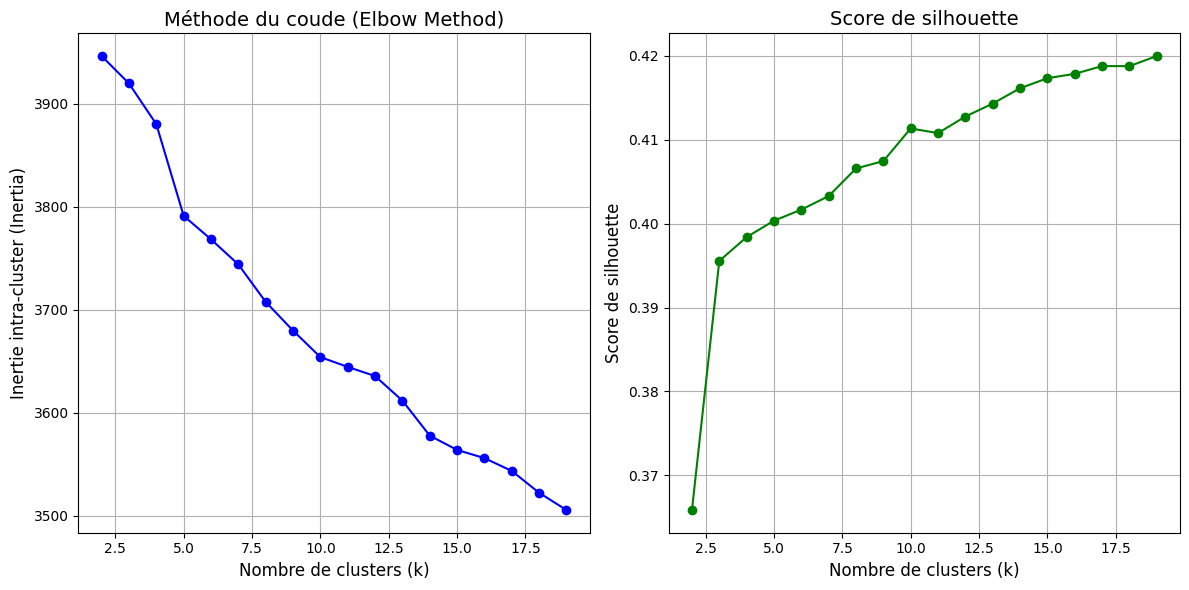

In [11]:
# Initialiser les listes pour stocker les métriques
inertia = []  
sil_scores = []
k_range = range(2, 20) 

# Calcul des métriques pour chaque k
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X) 
    inertia.append(kmeans.inertia_) 
    sil_scores.append(silhouette_score(X, kmeans.labels_)) 

# Visualisation des résultats
plt.figure(figsize=(12, 6))

# Méthode du coude
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
plt.title('Méthode du coude (Elbow Method)', fontsize=14)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Inertie intra-cluster (Inertia)', fontsize=12)
plt.grid(True)

# Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, marker='o', linestyle='-', color='g')
plt.title('Score de silhouette', fontsize=14)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Score de silhouette', fontsize=12)
plt.grid(True)

# Affichage des graphiques côte à côte
plt.tight_layout()
plt.show()

**Étape 4 : Application du modèle K-means**

In [12]:
# Appliquer K-means avec k optimal
best_k = 6
kmeans = KMeans(n_clusters=best_k, init='k-means++',  random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Sauvegarder le modèle K-Means
joblib.dump(kmeans, 'Models/kmeans_model.joblib')

print("Modèle K-Means sauvegardé sous 'Models/kmeans_model.joblib'.")

Modèle K-Means sauvegardé sous 'Models/kmeans_model.joblib'.


In [82]:
# Ajouter les labels du cluster au DataFrame
df[['title', 'author_keywords', 'cluster']].head(25)

,title,author_keywords,cluster
0,Oscillations induced by quiescent adult female...,"bifurcation-analysis , population-dynamics , ...",5
1,Reducing the interprocessors migrations of the...,"real time scheduling , ekg , semi-partitionin...",2
2,Stig: a generic intelligent tutoring system a ...,"intelligent tutoring system , multi-agents sy...",4
3,Improve security of web browser with stand-alo...,"home users e-learning security awareness , br...",4
4,Determining the potato samples processed manne...,"inorganic fertilizers , mineral-content , sof...",4
5,An intelligent machine learning based routing ...,"ad hoc networks , clustering-algorithm , prot...",3
6,Dynamics of a class of viral infection models ...,"equations , hbv viral infection , reaction-di...",5
7,Square roots and nth roots in pseudo-michael a...,"banach-algebras pseudo michael algebra , loca...",0
8,Harmonic calculus in involutive p-banach algeb...,,2
9,Ahybrid model for arabic script recognition ba...,"handwriting recognition , arabic database , d...",4


**Étape 5 : Visualisation des clusters (réduction de dimensionnalité)**

- Visualisation avec PCA

In [13]:
from sklearn.decomposition import PCA
import plotly.express as px

# Réduction de la dimensionnalité à 2D avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray()) 

# Création d'un DataFrame pour la visualisation
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = kmeans.labels_  

# Visualisation interactive avec Plotly
fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color=df_pca['cluster'].astype(str),  
    title='Clustering K-means++ avec PCA',
    labels={'cluster': 'Cluster'}
)
fig.show()

In [84]:
from sklearn.manifold import TSNE


# Réduction de la dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X.toarray())  

# Création d'un DataFrame pour la visualisation
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = kmeans.labels_  

# Visualisation interactive avec Plotly
fig = px.scatter(
    df_tsne,
    x='TSNE1',
    y='TSNE2',
    color=df_tsne['cluster'].astype(str), 
    title='Clustering K-means avec t-SNE',
    labels={'cluster': 'Cluster'}
)
fig.show()

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



**Étape 6 : Évaluation de la performance du modèle**

In [15]:
# Calcul du score de silhouette
silhouette_avg = silhouette_score(X, df['cluster'])
print(f"Score de silhouette moyen : {silhouette_avg}")

Score de silhouette moyen : 0.4016691457432389


## Test : Journal Recommandation System

- Input

In [86]:
abstract="We investigate a novel category of Caputo fractional Moreau's sweeping process, formulated in a real Hilbert space, by the inclusion below −Dtα0cu(t)∈NΞ(t)(A(Dtα0cu(t))+Bu(t)). Our primary focus is to develop a framework for proving the unique solvability of the fractional Moreau's sweeping processes, namely, we deliver a fractional version of the Moreau's type catching-up algorithm for the sweeping process being considered. Moreover, the established abstract results are applied to investigate a complicated dynamical viscoelastic contact problem with fractional constitutive laws."
key_words="Existence and uniqueness, Fractional differential inclusion, Sweeping process, Variational inequality, Viscoelastic materials"
title="A novel fractional Moreau's sweeping process with applications"
Reel_journal_name="Applied Mathematics and Computation"
new_text = title+' '+abstract+' '+key_words

In [87]:
new_text

"A novel fractional Moreau's sweeping process with applications We investigate a novel category of Caputo fractional Moreau's sweeping process, formulated in a real Hilbert space, by the inclusion below −Dtα0cu(t)∈NΞ(t)(A(Dtα0cu(t))+Bu(t)). Our primary focus is to develop a framework for proving the unique solvability of the fractional Moreau's sweeping processes, namely, we deliver a fractional version of the Moreau's type catching-up algorithm for the sweeping process being considered. Moreover, the established abstract results are applied to investigate a complicated dynamical viscoelastic contact problem with fractional constitutive laws. Existence and uniqueness, Fractional differential inclusion, Sweeping process, Variational inequality, Viscoelastic materials"

- Nettoyage de l'input

In [88]:
new_text = clean_text(new_text)
new_text = remove_stopwords(new_text)
new_text = lemmatize_text(new_text)

- Encodage de l'input

In [89]:
# Recharger le TF-IDF Vectorizer
tfidf_loaded = joblib.load('Tokenizers/tfidf_vectorizer.joblib')

# Utiliser le vectorizer chargé pour transformer un nouveau texte
X_new = tfidf_loaded.transform([new_text])

- Chargement du model et prediction

In [92]:
# Recharger le modèle K-Means
kmeans_loaded = joblib.load('Models/kmeans_model.joblib')

# Réutiliser le modèle chargé pour prédire de nouvelles données
cluster_num = kmeans_loaded.predict(X_new)

In [93]:
cluster_num

array([0])

- **Recommandation avec le Filtrage des lignes du même cluster avec le score sjr_score le plus élevé**

In [104]:
# Convertir 'sjr_score' en type float, en gérant les éventuelles erreurs
df['sjr_score'] = pd.to_numeric(df['sjr_score'], errors='coerce')

# # Supprimer les lignes où 'sjr_score' est NaN après la conversion
# df = df.dropna(subset=['sjr_score'])

# Trouver les lignes du même cluster
same_cluster_df = df[df['cluster'] == cluster_num[0]]

# Trier les lignes par sjr_score en ordre décroissant et sélectionner les 10 premières
top_10_high_sjr = same_cluster_df.sort_values(by='sjr_score', ascending=False).head(10)

print("Les 10 lignes ayant le même cluster avec les scores SJR les plus élevés :")
print("- Le journale originale : ", Reel_journal_name)
top_10_high_sjr[["journal_name", 'sjr_score']].drop_duplicates()


Les 10 lignes ayant le même cluster avec les scores SJR les plus élevés :
- Le journale originale :  Applied Mathematics and Computation


,journal_name,sjr_score
6809,Springer Proceedings in Mathematics & Statistics,770.000
8771,International Conference on Differential Equat...,153.000
6881,Mathematics Conference,153.000
6869,Proceedings Of The Mathematics Conference,153.000
8786,Nature Genetics,19.882
8784,Nature Biotechnology,13.241
6794,Biosensors and Bioelectronics,11.190
7424,IEEE Transactions on Image Processing,10.656
6877,"Lancet Neurology, The",10.241


- **Utiliser KNN pour sélectionner les 10 plus proches voisins**

In [105]:
from sklearn.neighbors import NearestNeighbors

# Étape 1 : Filtrer les lignes avec le même cluster_num
same_cluster_df = df[df['cluster'] == cluster_num[0]]

# Étape 2 : Combiner les colonnes `title`, `abstract`, et `author_keywords`
same_cluster_df['combined_text'] = (
    same_cluster_df['title'] + ' ' +
    same_cluster_df['abstract'] + ' ' +
    same_cluster_df['author_keywords']
)

# Étape 3 : Nettoyer et prétraiter les textes
same_cluster_df['processed_text'] = same_cluster_df['combined_text'].apply(clean_text)
same_cluster_df['processed_text'] = same_cluster_df['processed_text'].apply(remove_stopwords)
same_cluster_df['processed_text'] = same_cluster_df['processed_text'].apply(lemmatize_text)

# Étape 4 : Transformer les textes en vecteurs TF-IDF
X_cluster = tfidf_loaded.transform(same_cluster_df['processed_text'])


C:\Users\admin\AppData\Local\Temp\ipykernel_13604\405110118.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_13604\405110118.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp\ipykernel_13604\405110118.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [106]:
# Étape 5 : Appliquer KNN pour trouver les 10 plus proches voisins
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(X_cluster)

# Trouver les indices des 10 plus proches voisins pour `new_text`
distances, indices = knn.kneighbors(X_new)

# Étape 6 : Récupérer les 10 lignes correspondantes
closest_neighbors = same_cluster_df.iloc[indices[0]]

In [108]:
print("Les 10 plus proches voisins dans le même cluster :")
closest_neighbors[["journal_name", 'sjr_score']].drop_duplicates()

Les 10 plus proches voisins dans le même cluster :


,journal_name,sjr_score
1899,Applied Mathematics and Computation,1.026
1910,Applied Mathematics and Optimization,0.916
1925,Communications in Nonlinear Science and Numeri...,0.919
818,Communications in Mathematical Biology and Neu...,0.200
2701,Journal of Nonlinear Functional Analysis,0.308
3627,Dynamics of Partial Differential Equations,0.814
2707,Advances in Operator Theory,0.440
4982,Fractal and Fractional,3.857
2035,Zeitschrift fur Angewandte Mathematik und Physik,0.931


# Avec BERT

In [ ]:
# from tqdm import tqdm

# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# import plotly.express as px
# from transformers import BertTokenizer, TFBertModel
# import tensorflow as tf
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
# import logging
# logging.getLogger('tensorflow').setLevel(logging.ERROR)
# from sklearn.metrics import silhouette_score

# df = pd.read_csv("Training_data.csv")
# df.head(2)

# # Étape 1 : Encodage avec BERT
# # Charger le tokenizer et le modèle BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = TFBertModel.from_pretrained('bert-base-uncased')

# def encode_texts_in_batches(texts, batch_size=32):
#     embeddings = []
#     # Utilisation de tqdm pour la barre de progression
#     for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches"):
#         batch_texts = texts[i:i + batch_size]
#         inputs = tokenizer(batch_texts, return_tensors='tf', padding=True, truncation=True, max_length=512)
#         outputs = model(inputs)
#         batch_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()
#         embeddings.append(batch_embeddings)
#     return np.vstack(embeddings)

# bert_embeddings = encode_texts_in_batches(df['combined_text'].tolist(), batch_size=16)


# # Étape 2 : Méthode Elbow pour déterminer le meilleur nombre de clusters
# inertia = []
# silhouette_scores = []
# k_values = range(2, 11)

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     labels = kmeans.fit_predict(bert_embeddings)
#     inertia.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(bert_embeddings, labels))

# # Visualisation interactive de la méthode Elbow
# elbow_fig = px.line(
#     x=list(k_values), y=inertia, markers=True,
#     title='Méthode Elbow pour sélectionner le meilleur k',
#     labels={'x': 'Nombre de Clusters (k)', 'y': 'Inertie'}
# )
# elbow_fig.show()

# # Visualisation des scores de silhouette
# silhouette_fig = px.line(
#     x=list(k_values), y=silhouette_scores, markers=True,
#     title='Score de Silhouette pour différents k',
#     labels={'x': 'Nombre de Clusters (k)', 'y': 'Score de Silhouette'}
# )
# silhouette_fig.show()

# # Sélection automatique du meilleur k (par ex., en se basant sur le score de silhouette maximal)
# best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
# print(f"Meilleur k sélectionné : {best_k}")

# # Étape 3 : Réduction de dimensionnalité avec PCA pour la visualisation
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(bert_embeddings)
# data['pca_x'] = pca_result[:, 0]
# data['pca_y'] = pca_result[:, 1]df.isna().sum()

# # Étape 4 : Clustering avec le meilleur k
# kmeans = KMeans(n_clusters=best_k, random_state=42)
# data['cluster'] = kmeans.fit_predict(bert_embeddings)

# # Visualisation des clusters dans l'espace PCA
# fig = px.scatter(
#     data, x='pca_x', y='pca_y', color=data['cluster'].astype(str),
#     title=f'Clusters des Textes avec k={best_k}',
#     labels={'color': 'Cluster'},
#     hover_data=['title', 'abstract', 'author keywords', 'Nom de la revue']
# )
# fig.show()

# # Étape 5 : Analyse des clusters
# # Afficher quelques exemples par cluster
# for cluster_num in range(best_k):
#     print(f"\nCluster {cluster_num}:")
#     print(data[data['cluster'] == cluster_num][['title', 'abstract']].head(5))
